# ADAPT-CS-VQE

`adapt_cs_vqe.py` combines CS-VQE with the ansatz construction methodology of [ADAPT-VQE](https://www.nature.com/articles/s41467-019-10988-2) and [qubit-ADAPT-VQE](https://doi.org/10.1103/PRXQuantum.2.020310). This allows us to simulataneously search for the best contextual subspace for a given number of qubits and build effective ansatze for said space.

In [1]:
from symred.symplectic_form import PauliwordOp, StabilizerOp, AnsatzOp, ObservableOp
from symred.adapt_cs_vqe import ADAPT_CS_VQE
from symred.build_model import build_molecule_for_projection
import json
import numpy as np
import openfermion as of
import openfermionpyscf as ofpyscf

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_ST

# Build the molecule

In [3]:
# Set molecule parameters
speciesname = 'BeH2_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

delete_input = True
delete_output = True
cisd=1
ccsd=1
fci =1 # wouldn't advise turning this on over 32 qubits!

# Run pyscf.
molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
calculated_molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=cisd,run_ccsd=ccsd,run_fci=fci)
model = build_molecule_for_projection(calculated_molecule, basis_weighting='ham_coeff')

------------------------------------------------
Information concerning the full system:
------------------------------------------------
Number of qubits in full problem: 14
The Hartree-Fock state is |11111100000000>
HF   energy = -15.56135281
MP2  energy = -15.58372501
CISD energy = -15.59405704
CCSD energy = -15.59437836
FCI energy  = -15.59474615
------------------------------------------------
Tapering information:
------------------------------------------------
We are able to taper 5 qubits from the Hamiltonian
The symmetry basis/sector is:
-1 ZIZIIZIZIZZIIZ +
-1 IZIZIZIZIZIZIZ +
1 IIIIZZIIIIIIZZ +
1 IIIIIIZZIIIIII +
1 IIIIIIIIZZIIII
The tapered Hartree-Fock state is |111000000>
------------------------------------------------
CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -15.56135280766842
Symmetry generators:    
1 IIIIIIIIZ +
1 IIIIIIIZI +
1 IIIIIIZII +
1 IIIIIZIII +
1 IIIIZIIII +
1 IIIZZIIII +
-1 IIZIIIIZI +
1 IZZZZIZIZ
Clique 

/home/tweaving/anaconda3/lib/python3.8/site-packages/symred/S3_projection.py:302: ComplexWarning: Casting complex values to real discards the imaginary part
  ham_nc_dict = {op:float(coeff) for op,coeff in self.noncontextual_operator.to_dictionary.items()}


# Initiate the `ADAPT_CS_VQE` class

Here we input the tapered Hamiltonian, UCC operator and Hartree-Fock state

In [4]:
adapt = ADAPT_CS_VQE(model.ham_tap, model.ucc_tap, model.hf_tapered)

Suppose we have access to $N$ qubits - we may run the `greedy_adaptive_search` method, specifying a search depth $d$, to find a good contextual subspace of size $N$ with an ansatz constructed therein by running [qubit-ADAPT-VQE]( 	
https://doi.org/10.1103/PRXQuantum.2.020310). This works as follows:

1. Define the ansatz pool (e.g. terms of the UCCSD(T) operator)
2. Choose the stabilizer pool (by default, the full set is taken here, however if you have some additional intuition regarding the stabilizers and their importance you might wish to modify this)
3. Run over stabilizer relaxation combinations of size $d$
4. For each set of indices this will restrict the ansatz pool (i.e. perform the noncontextual projection over the pool)
5. Run [qubit-ADAPT-VQE](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.020310) over the restricted ansatz pool
6. Repeat for each combination and choose the stabilizers that minimize the energy
7. Remove those stabilizers from the stabilizer pool
8. Repeat steps 3-7 until the stabilizer pool is exhausted

What remains will be the best stabilizer relaxation ordering and ansatze for the corresponding contextual subspaces, as well as the contextual energy estimate.

In [5]:
stab_indices, energy, ansatz = adapt.adaptive_greedy_search(7, depth=2, maxterms=5, threshold=0.01, print_info=True)

--------------------------------------------
Using best gradient as termination criterion
--------------------------------------------

-------------------------------------------------
Searching for optimal 2-qubit contextual subspace
-------------------------------------------------

Testing stabilizer indices [2, 3, 4, 5, 6, 7, 8]
<!> The ansatz pool vanished under the noncontextual projection <!>

Testing stabilizer indices [1, 3, 4, 5, 6, 7, 8]
<!> The ansatz pool vanished under the noncontextual projection <!>

Testing stabilizer indices [1, 2, 4, 5, 6, 7, 8]
>>> Ansatz term #1 gradient = 2.729942565338206e-07.
<!> The new ansatz term achieved the gradient threshold <!>
<!> The ansatz pool has been exhausted <!>

Testing stabilizer indices [1, 2, 3, 5, 6, 7, 8]


/home/tweaving/anaconda3/lib/python3.8/site-packages/symred/S3_projection.py:450: ComplexWarning: Casting complex values to real discards the imaginary part
  np.array(fix_stabilizers.coeff_vec, dtype=int),
/home/tweaving/anaconda3/lib/python3.8/site-packages/symred/S3_projection.py:450: ComplexWarning: Casting complex values to real discards the imaginary part
  np.array(fix_stabilizers.coeff_vec, dtype=int),


>>> Ansatz term #1 gradient = 2.729942529811069e-07.
<!> The new ansatz term achieved the gradient threshold <!>

Testing stabilizer indices [1, 2, 3, 4, 6, 7, 8]
<!> The ansatz pool vanished under the noncontextual projection <!>

Testing stabilizer indices [1, 2, 3, 4, 5, 7, 8]
>>> Ansatz term #1 gradient = 0.09984271491565622.
>>> Ansatz term #2 gradient = 5.737986227671854e-05.
<!> The new ansatz term achieved the gradient threshold <!>
<!> The ansatz pool has been exhausted <!>

Testing stabilizer indices [1, 2, 3, 4, 5, 6, 8]
<!> The ansatz pool vanished under the noncontextual projection <!>

Testing stabilizer indices [1, 2, 3, 4, 5, 6, 7]
<!> The ansatz pool vanished under the noncontextual projection <!>

Testing stabilizer indices [0, 3, 4, 5, 6, 7, 8]
>>> Ansatz term #1 gradient = 0.16317821141041478.
>>> Ansatz term #2 gradient = 0.0004143616194305366.
<!> The new ansatz term achieved the gradient threshold <!>
<!> The ansatz pool has been exhausted <!>

Testing stabilizer

>>> Ansatz term #3 gradient = 0.09652414335389103.
>>> Ansatz term #4 gradient = 0.0028318459445220157.
<!> The new ansatz term achieved the gradient threshold <!>

Testing stabilizer indices [0, 2, 4, 7, 8]
>>> Ansatz term #1 gradient = 0.09984271491565089.
>>> Ansatz term #2 gradient = 0.09652427134942165.
>>> Ansatz term #3 gradient = 0.011012547062268396.
>>> Ansatz term #4 gradient = 0.0021495070790606974.
<!> The new ansatz term achieved the gradient threshold <!>

Testing stabilizer indices [0, 2, 3, 7, 8]
>>> Ansatz term #1 gradient = 0.12224165368010986.
>>> Ansatz term #2 gradient = 0.09970949513138905.
>>> Ansatz term #3 gradient = 0.0964270008329855.
>>> Ansatz term #4 gradient = 0.01416488763549495.
>>> Ansatz term #5 gradient = 0.003009062170541199.
<!> The new ansatz term achieved the gradient threshold <!>
<!> ADAPT-VQE reached the maximum number of ansatz terms <!>

Testing stabilizer indices [0, 2, 3, 4, 8]
>>> Ansatz term #1 gradient = 0.09984271491565089.
>>> Ansatz

>>> Ansatz term #2 gradient = 0.16323071211191653.
>>> Ansatz term #3 gradient = 0.13641709717138895.
>>> Ansatz term #4 gradient = 0.13211634946367568.
>>> Ansatz term #5 gradient = 0.09339617800531208.
<!> ADAPT-VQE reached the maximum number of ansatz terms <!>

Testing stabilizer indices [0, 1, 7]
>>> Ansatz term #1 gradient = 0.15368933943397423.
>>> Ansatz term #2 gradient = 0.13915682688575615.
>>> Ansatz term #3 gradient = 0.09261949103716738.
>>> Ansatz term #4 gradient = 0.09007863036056385.
>>> Ansatz term #5 gradient = 0.027901121598411294.
<!> ADAPT-VQE reached the maximum number of ansatz terms <!>

Testing stabilizer indices [0, 1, 2]
>>> Ansatz term #1 gradient = 0.16643680847659326.
>>> Ansatz term #2 gradient = 0.13015466160372924.
>>> Ansatz term #3 gradient = 0.09447770255291665.
>>> Ansatz term #4 gradient = 0.09166308091053388.
>>> Ansatz term #5 gradient = 0.027861418015715955.
<!> ADAPT-VQE reached the maximum number of ansatz terms <!>

6-qubit CS-VQE energy is

In [6]:
from symred.utils import exact_gs_energy
obs = model.contextual_subspace_projection(stab_indices)
obs = ObservableOp(obs.symp_matrix, obs.coeff_vec)
exact_cs_energy = exact_gs_energy(obs.to_sparse_matrix)[0]

print(f'The absolute error of the contextual energy with respect to the FCI energy is {exact_cs_energy - model.fci_energy}')
print(f'The absolute error of the ansatz with respect to the FCI energy is {energy - model.fci_energy}')

The absolute error of the contextual energy with respect to the FCI energy is 0.00033615825496191576
The absolute error of the ansatz with respect to the FCI energy is 0.012832268764052301


Whilst we have found a good contextual subspace, the ansatz is not achieving chemical accuracy. We can run ADAPT-VQE just in the chosen subsapce to improve its precision.

In [7]:
energy, ansatz = adapt.ADAPT_VQE(stab_indices, maxterms=15, print_info=True)

>>> Ansatz term #1 gradient = 0.16643680847659326.
>>> Ansatz term #2 gradient = 0.1632307121119183.
>>> Ansatz term #3 gradient = 0.1654418728770466.
>>> Ansatz term #4 gradient = 0.15268457388256707.
>>> Ansatz term #5 gradient = 0.14312385032505937.
>>> Ansatz term #6 gradient = 0.1269861588183545.
>>> Ansatz term #7 gradient = 0.1332729324494739.
>>> Ansatz term #8 gradient = 0.12057967838044803.
>>> Ansatz term #9 gradient = 0.09184392955351939.
>>> Ansatz term #10 gradient = 0.08937493944656794.
>>> Ansatz term #11 gradient = 0.01361338209570917.
>>> Ansatz term #12 gradient = 0.010833231531762522.
>>> Ansatz term #13 gradient = 0.010516592314573359.
>>> Ansatz term #14 gradient = 0.009796133769009785.
<!> The new ansatz term achieved the gradient threshold <!>


Running a VQE routine over this new ansatz yields an improved error:

In [8]:
ref_state = model.hf_tapered[model.free_qubit_indices]
ansatz.coeff_vec = np.zeros_like(ansatz.coeff_vec)
opt_out, interim = obs.VQE(ansatz, ref_state, maxiter=20)

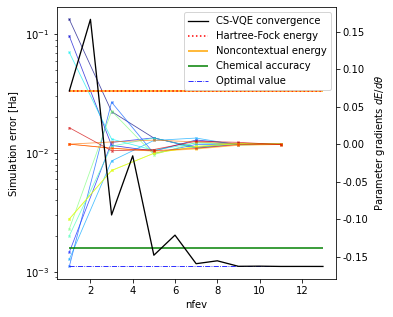

In [10]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig,axis = plt.subplots(figsize = (5,5))

# plot the VQE convergence
X, Y = zip(*interim['values'])
X = np.array(X)
Y = np.array(Y)
Y_error = Y - model.fci_energy
axis.plot(X, Y_error, label='CS-VQE convergence', color='black', zorder=4, lw=1.3)

# plot the energy targets
nfev      = X[-1]
hf_energy = model.hf_energy - model.fci_energy
noncon    = model.noncontextual_energy - model.fci_energy
target    = min(Y_error)
chemacc   = 0.0016

axis.hlines(hf_energy, 1, nfev, color='red',ls=':',label='Hartree-Fock energy', zorder=3)
axis.hlines(noncon, 1, nfev, color='orange', label='Noncontextual energy', zorder=2)
axis.hlines(chemacc, 1, nfev, color='green', label='Chemical accuracy', zorder=2)
axis.hlines(target, 1, nfev, color='blue', label='Optimal value', ls='-.', lw=0.8, zorder=3)

# plot the parameter gradients
axis_grad = axis.twinx()
X_grad, Y_grad_list = zip(*interim['gradients'])
for index, Y_grad in enumerate(zip(*Y_grad_list)):
    Y_grad = np.array(Y_grad)
    c = plt.cm.jet(index/(len(Y_grad_list[0])))
    axis_grad.plot(X_grad, Y_grad, color=c, lw=0.8, alpha=0.7, marker='x', ms=2)

axis.set_xlabel('nfev')#, fontname=font)    
axis.set_ylabel('Simulation error [$\mathrm{Ha}$]', fontsize=10)#,fontname = font)
axis_grad.set_ylabel('Parameter gradients $dE/d\\theta$', fontsize=10)#,fontname = font)
axis_grad.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axis.set_yscale('log')
axis.set_zorder(axis_grad.get_zorder()+1)
axis.set_frame_on(False)
axis.legend()